In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.sql.functions import col
from pyspark.sql.functions import desc
import numpy as np

In [5]:
spark = SparkSession.builder.appName("U-Pick").getOrCreate()
ruta_modelo="file:////home/student/SIC_Big_Data_CDC-develop-chris/ModeloEntrenado"
modelo_cargado=CrossValidatorModel.load(ruta_modelo)

In [12]:
tweets = spark.read.table('proyecto_final.tweets')

2023-07-26 02:36:17,297 WARN conf.HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
2023-07-26 02:36:17,297 WARN conf.HiveConf: HiveConf of name hive.stats.retries.wait does not exist
2023-07-26 02:36:18,132 WARN metastore.ObjectStore: Failed to get database global_temp, returning NoSuchObjectException


In [13]:
predicciones_df=modelo_cargado.transform(tweets)

In [14]:
predicciones_df.show()

+--------------+-------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|       usuario| siglas|             mensaje|likes|            palabras|            features|       rawPrediction|         probability|prediction|
+--------------+-------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|       jason64|    UNA|La Universidad de...|  540|[la, universidad,...|(262144,[977,8786...|[5.47025979197899...|[0.99580751269542...|       0.0|
|        dale53|   UCAM|En la Universidad...|  959|[en, la, universi...|(262144,[5374,718...|[5.76648339322355...|[0.99687902320371...|       0.0|
|     curryryan|    URI|En la Universidad...|  250|[en, la, universi...|(262144,[32297,36...|[-4.7482992105659...|[0.00859196087284...|       1.0|
|       david47|    UPO|En la Universidad...|  164|[en, la, universi...|(262144,[23484,32...|[5.35309780429600...|[0.9

In [15]:
satisfaccion_df = predicciones_df.select("siglas", "prediction").groupby("siglas").mean("prediction")
satisfaccion_df_pd = satisfaccion_df.toPandas()
satisfaccion_df_pd.rename(columns={'avg(prediction)':'Porcentaje de satisfacción'}, inplace = True)
porcentaje = [x*100 for x in satisfaccion_df_pd['Porcentaje de satisfacción']]
satisfaccion_df_pd['Porcentaje de satisfacción'] = porcentaje
satisfaccion_ucm = satisfaccion_df_pd['Porcentaje de satisfacción'][57]

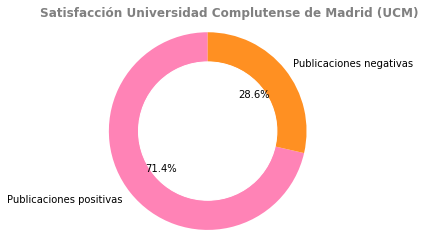

In [16]:
categorias = ['Publicaciones positivas', 'Publicaciones negativas']
valores = [satisfaccion_ucm, 100-satisfaccion_ucm]
colores_pasteles = ['#FF83B6', '#FF9022']
fig, ax = plt.subplots() 
pie = ax.pie(valores, labels=categorias, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3), colors=colores_pasteles)
centro_circulo = plt.Circle((0, 0), 0.70, color='white') 
ax.add_artist(centro_circulo)
ax.axis('equal')
ax.set_title('Satisfacción Universidad Complutense de Madrid (UCM)', loc = 'left', fontdict={'fontsize':12, 'fontweight':'bold', 'color':'gray'})
plt.show()

In [17]:
satisfaccion_df = predicciones_df.select("siglas", "prediction").groupby("siglas").mean("prediction").orderBy(desc("avg(prediction)")).limit(10)

In [18]:
dfTop10=satisfaccion_df.toPandas()

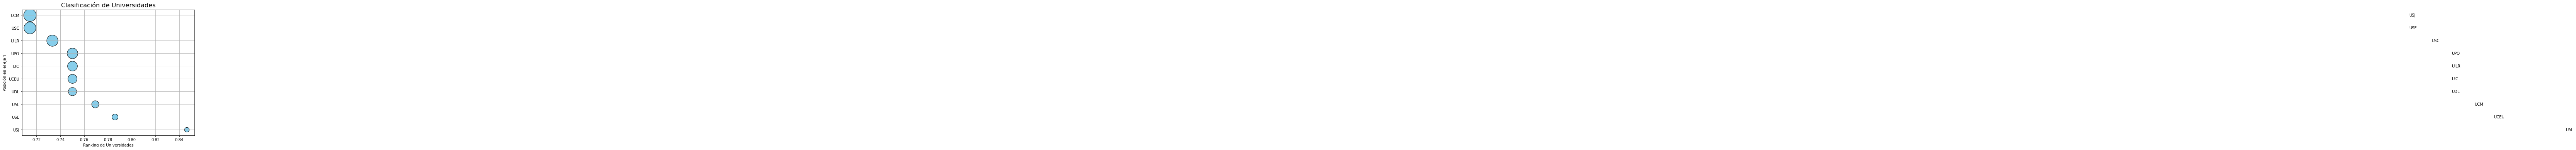

In [57]:
dfTop10.rename(columns={"avg(prediction)":"satisfaccion"}, inplace=True) 
unis = sorted(dfTop10['siglas'],reverse=False)
posiciones_y=np.arange(10) 
tamanio_circulos = [150 + pos * 100 for pos in posiciones_y] 
plt.figure(figsize=(8, 6)) 
for universidad, ranking, y, size in zip(unis, sorted(dfTop10['satisfaccion'],reverse=True), posiciones_y, tamanio_circulos): 
    plt.scatter(ranking, y, s=size, color='skyblue', edgecolor='black') 
    plt.text(ranking + 2, y, universidad, ha='left', va='center')
plt.xlabel('Ranking de Universidades') 
plt.ylabel('Posición en el eje Y') 
plt.title('Clasificación de Universidades', fontsize=16) 
plt.yticks(posiciones_y, dfTop10['siglas'])
plt.grid(True) 
#plt.tight_layout() 
plt.show()

In [45]:
sorted(dfTop10['siglas'],reverse=False)

['UAL', 'UCEU', 'UCM', 'UDL', 'UIC', 'UILR', 'UPO', 'USC', 'USE', 'USJ']

In [56]:
unis

['UAL', 'UCEU', 'UCM', 'UDL', 'UIC', 'UILR', 'UPO', 'USC', 'USE', 'USJ']